In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [2]:
# Initial parameters
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96, 96, 3)
data = []
labels = []

In [3]:
# Load image files from the dataset
image_files = [f for f in glob.glob(r'gender_dataset_face/**/*', recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [4]:
# Converting images to arrays and labeling the categories
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (img_dims[0], img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    label = 1 if label == "woman" else 0
    labels.append(label)

print(f"Loaded {len(data)} images with labels.")

Loaded 11135 images with labels.


In [5]:
# Preprocessing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

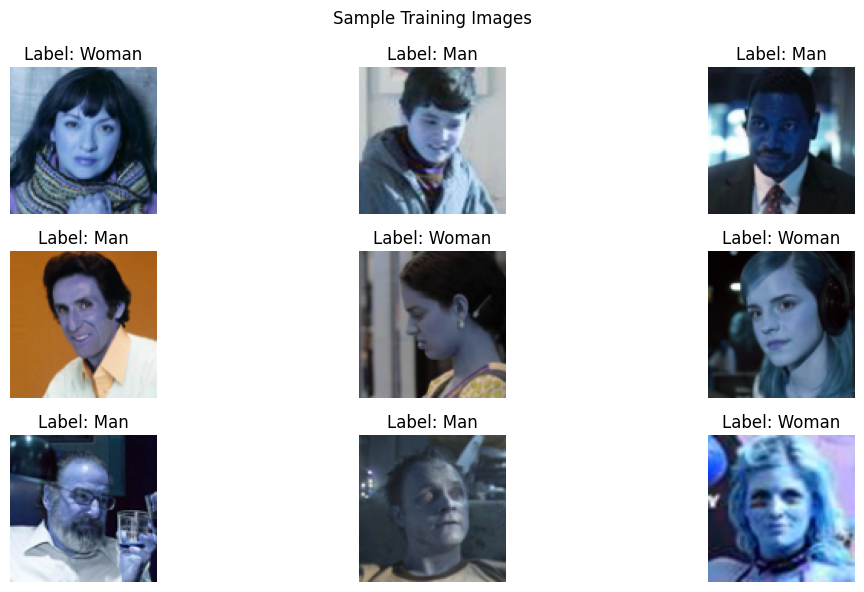

In [6]:
# Visualize sample images
plt.figure(figsize=(12, 6))
for i in range(9):
    idx = random.randint(0, len(trainX) - 1)
    plt.subplot(3, 3, i + 1)
    plt.imshow(trainX[idx])
    plt.title(f"Label: {'Woman' if np.argmax(trainY[idx]) == 1 else 'Man'}")
    plt.axis('off')
plt.suptitle("Sample Training Images")
plt.tight_layout()
plt.savefig('Images/sample_images.png')
plt.show()

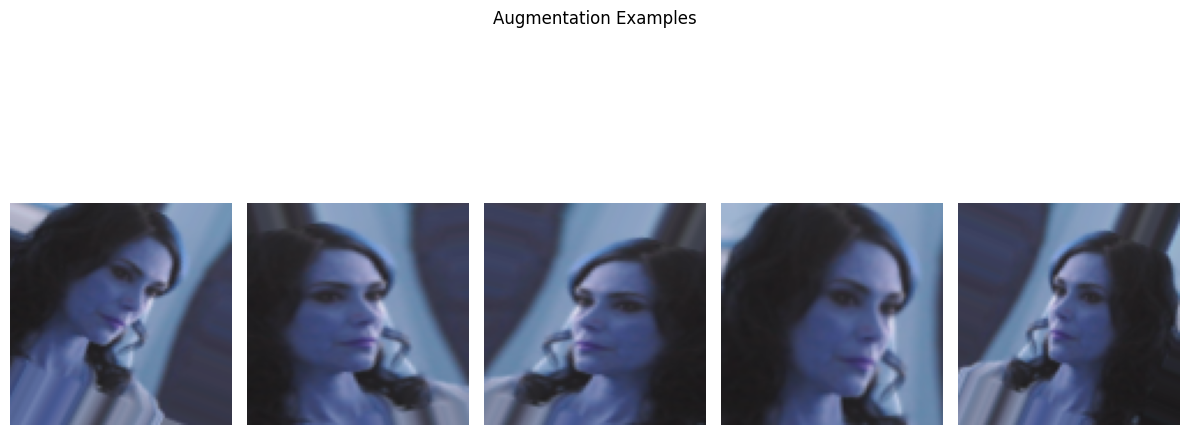

In [7]:
# Augmenting the dataset
aug = ImageDataGenerator(
    rotation_range=25, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode="nearest"
)

# Visualize data augmentation
sample_image = trainX[0]
aug_iter = aug.flow(np.expand_dims(sample_image, axis=0), batch_size=1)
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    aug_image = next(aug_iter)[0]
    plt.imshow(aug_image)
    plt.axis('off')
plt.suptitle("Augmentation Examples")
plt.tight_layout()
plt.savefig('Images/augmented_examples.png')
plt.show()

In [8]:
# Define the model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

    model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

# Build and compile the model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=2)

opt = Adam(learning_rate=lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Train the model
H = model.fit(
    aug.flow(trainX, trainY, batch_size=batch_size),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // batch_size,
    epochs=epochs,
    verbose=1
)

# Save the model to disk in .h5 format
model.save('Model/gender_detection.h5')

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 133s 854ms/step - accuracy: 0.6843 - loss: 0.8186 - val_accuracy: 0.4881 - val_loss: 1.1480
Epoch 2/100
  1/139 ━━━━━━━━━━━━━━━━━━━━ 1:47 779ms/step - accuracy: 0.6406 - loss: 0.8296

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.6406 - loss: 0.8296 - val_accuracy: 0.4881 - val_loss: 1.1399
Epoch 3/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 114s 820ms/step - accuracy: 0.7588 - loss: 0.5303 - val_accuracy: 0.4881 - val_loss: 1.5278
Epoch 4/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7656 - loss: 0.5149 - val_accuracy: 0.4881 - val_loss: 1.4923
Epoch 5/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 107s 767ms/step - accuracy: 0.7914 - loss: 0.4732 - val_accuracy: 0.5819 - val_loss: 0.8259
Epoch 6/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8594 - loss: 0.4125 - val_accuracy: 0.5752 - val_loss: 0.8405
Epoch 7/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 102s 729ms/step - accuracy: 0.7955 - loss: 0.4412 - val_accuracy: 0.8101 - val_loss: 0.4282
Epoch 8/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7500 - loss: 0.5009 - val_accuracy: 0.8038 - val_loss: 0.4216
Epoch 9/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 101s 728ms/step - accuracy: 0.8223 - loss: 0.4029 - 

In [10]:
# Generate predictions
predY = model.predict(testX, batch_size=batch_size)  # Model predictions (probabilities)
predY = np.argmax(predY, axis=1)  # Convert probabilities to class labels
trueY = np.argmax(testY, axis=1)  # True labels (binary 0 or 1)

# Compute confusion matrix
cm = confusion_matrix(trueY, predY)

# Extract TP, FP, FN, TN
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix
print("Confusion Matrix:")
print(cm)
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Negatives (TN): {tn}")

# Compute additional metrics
accuracy = accuracy_score(trueY, predY)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# Classification report for more details
print("\nClassification Report:")
print(classification_report(trueY, predY, target_names=["Man", "Woman"]))


35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step
Confusion Matrix:
[[1075   65]
 [  76 1011]]
True Positives (TP): 1011
False Positives (FP): 65
False Negatives (FN): 76
True Negatives (TN): 1075
Accuracy: 0.94
Precision: 0.94
Recall: 0.93
F1 Score: 0.93

Classification Report:
              precision    recall  f1-score   support

         Man       0.93      0.94      0.94      1140
       Woman       0.94      0.93      0.93      1087

    accuracy                           0.94      2227
   macro avg       0.94      0.94      0.94      2227
weighted avg       0.94      0.94      0.94      2227



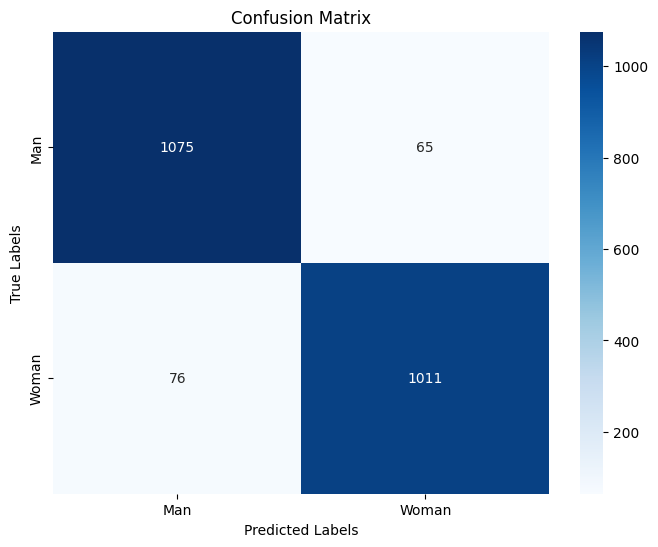

In [11]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Man", "Woman"], yticklabels=["Man", "Woman"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


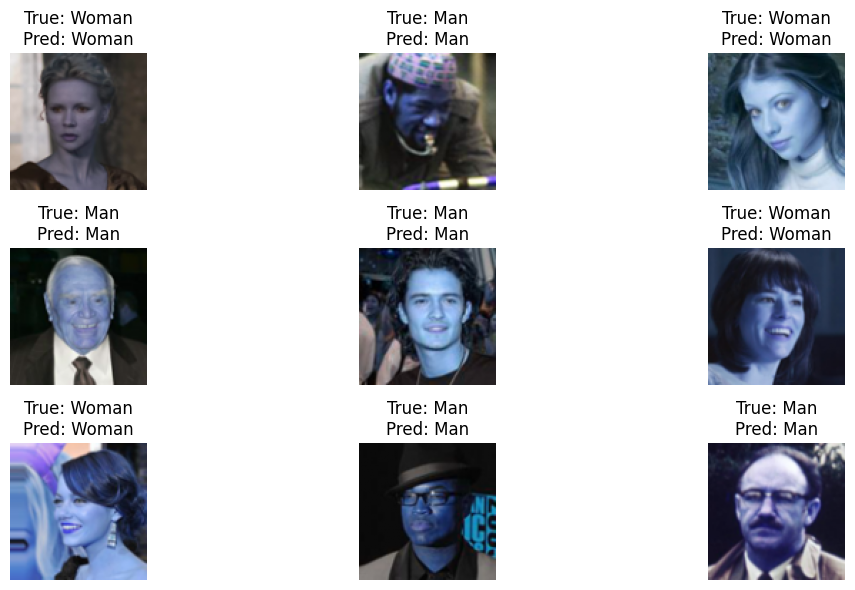

In [12]:
# Display predictions on test images
plt.figure(figsize=(12, 6))
for i in range(9):
    idx = random.randint(0, len(testX) - 1)
    plt.subplot(3, 3, i + 1)
    plt.imshow(testX[idx])
    pred_label = 'Woman' if predY[idx] == 1 else 'Man'
    true_label = 'Woman' if trueY[idx] == 1 else 'Man'
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('Images/test_predictions.png')
plt.show()

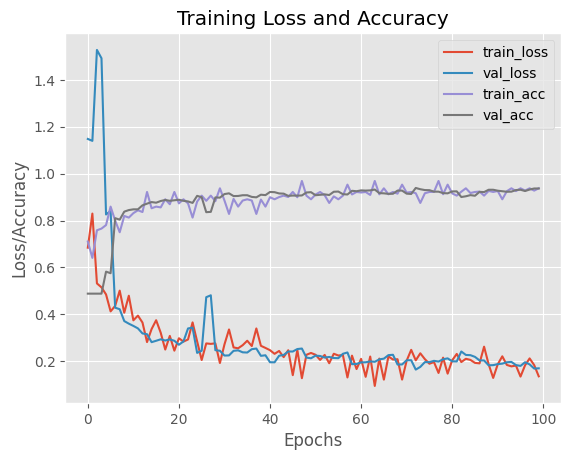

In [13]:
# Plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# Save the plot to disk
plt.savefig('Images/plot.png')